In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import json
import os
import tensorflow as tf
from object_detection.utils import dataset_util
from os.path import join as pj


In [2]:
DATA_ROOT = "data"
RAW_IMAGES = pj(DATA_ROOT, "raw-data")
PROCESSED_IMAGES = pj(DATA_ROOT, "img")
TRAIN_TF = pj(DATA_ROOT, "train.tfrecords")
TEST_TF = pj(DATA_ROOT, "test.tfrecords")
RAW_CSV_FILE = pj(DATA_ROOT, "via_region_data.csv")
PROCESSED_CSV_FILE = pj(DATA_ROOT, "via_region_data_processed.csv")


In [8]:
def process_bb(bb):
    bbox = cv2.boundingRect(bb)
    bbox = np.array(bbox)
    min_max_points = [bbox[:2], bbox[:2] + bbox[2:]]
    min_max_points = np.int0(min_max_points)
    return min_max_points.reshape(-1)


def process_row(row):
    img_path = row['filename']
    data_points = json.loads(row['region_shape_attributes'])
    if not data_points:
        raise ValueError("no data")
    bb_x = data_points['all_points_x']
    bb_y = data_points['all_points_y']
    bb = np.array([bb_x, bb_y]).T
    return img_path, bb, process_bb(bb)


In [24]:
def create_mask(shape, points):
    mask = np.zeros((shape[0], shape[1]))
    cv2.fillConvexPoly(mask, points.astype("int"), 1)
    mask = mask.astype(np.bool)
    return mask

In [5]:
df = pd.read_csv("data/via_region_data.csv")

In [6]:
df.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,andrew_1.jpeg,167574,{},1,0,"{""name"":""polygon"",""all_points_x"":[305,1207,112...","{""Region type"":""paper""}"
1,andrew_2.jpeg,188298,{},1,0,"{""name"":""polygon"",""all_points_x"":[377,264,1029...","{""Region type"":""paper""}"
2,andrew_3.jpeg,160000,{},1,0,"{""name"":""polygon"",""all_points_x"":[82,64,589,59...","{""Region type"":""paper""}"
3,andrew_4.jpeg,88354,{},1,0,"{""name"":""polygon"",""all_points_x"":[314,309,999,...","{""Region type"":""paper""}"
4,andrew_5.jpeg,78648,{},1,0,"{""name"":""polygon"",""all_points_x"":[427,393,875,...","{""Region type"":""paper""}"


In [9]:
row = df.iloc[0]
img_fn, bb, bound_rect = process_row(row)
img_path = pj(RAW_IMAGES, img_fn)
img = cv2.imread(img_path)

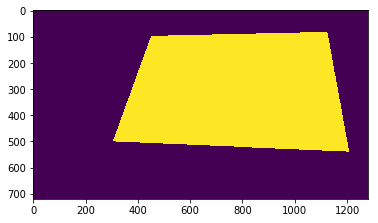

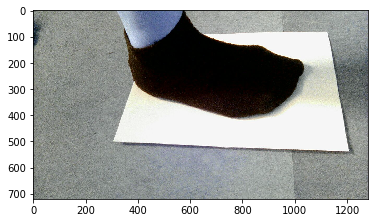

(<matplotlib.image.AxesImage at 0x7f95e17394e0>, None)

In [12]:
mask = np.zeros((img.shape[0], img.shape[1]))

cv2.fillConvexPoly(mask, bb, 1)
mask = mask.astype(np.bool)
plt.imshow(mask), plt.show()
plt.imshow(img), plt.show()

In [48]:
np.array([mask]).reshape([-1])

array([False, False, False, ..., False, False, False])

In [75]:
def create_tf_example(bb, filename, mask, shape):
    img_path = os.path.join(PROCESSED_IMAGES, filename)
    with tf.gfile.GFile(img_path, 'rb') as fid:
        encoded_jpg = fid.read()

    height = shape[0]  # Image height
    width = shape[1]  # Image width

    filename = filename.encode("utf-8")  # Filename of the image. Empty if image is not from file
    image_format = b'png'  # b'jpeg' or b'png'

    xmins = [bb[0]]  # List of normalized left x coordinates in bounding box (1 per box)
    xmaxs = [bb[2]]  # List of normalized right x coordinates in bounding box
    ymins = [bb[1]]  # List of normalized top y coordinates in bounding box (1 per box)
    ymaxs = [bb[3]]  # List of normalized bottom y coordinates in bounding box
    if xmins[0] > xmaxs[0] or ymins[0] > ymaxs[0]:
#         pass
#     else:
        print(bb, "#")

    classes_text = [tf.compat.as_bytes("paper")]  # List of string class name of bounding box (1 per box)
    classes = [1]  # List of integer class id of bounding box (1 per box)

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
        'image/object/mask': (dataset_util.float_list_feature(mask.astype(np.float32).reshape(-1).tolist()))
    }))
    return tf_example

In [76]:
marginise_to_norm_range = np.vectorize(lambda x: max(min(1.0, x), 0.0))

In [77]:
def normalise_images(in_path=RAW_IMAGES, out_path=PROCESSED_IMAGES, in_csv=RAW_CSV_FILE, out_csv=PROCESSED_CSV_FILE):
    df = pd.read_csv(in_csv)
    train_writer = tf.python_io.TFRecordWriter(TRAIN_TF)
    test_writer = tf.python_io.TFRecordWriter(TEST_TF)

    indexes = list(range(len(df)))
    np.random.shuffle(indexes)
    for ind in indexes:
        row = df.loc[ind]
        try:
            image, bb, bound_rect = process_row(row)
        except ValueError:
            continue

        img_path = pj(in_path, image)
        img = cv2.imread(img_path)
        bound_rect = bound_rect.astype("float")
        bound_rect[::2] = bound_rect[::2] / img.shape[1]
        bound_rect[1::2] = bound_rect[1::2] / img.shape[0]
        bound_rect = marginise_to_norm_range(bound_rect)
        bb = bb.astype("float")
        bb[:, 0] /= img.shape[1]
        bb[:, 1] /= img.shape[0]
        
        img = cv2.resize(img, (img.shape[1] * 300 // img.shape[0], 300))
#         img = cv2.resize(img, (300, 300))
        bb[:, 0] *= img.shape[1]
        bb[:, 1] *= img.shape[0]
        mask = create_mask(img.shape, bb)
#         plt.imshow(img), plt.show()
#         plt.imshow(mask.astype(np.float32)), plt.show()
        
        image = ".".join([image.split(".")[0], "png"])
        img_path = pj(out_path, image)
        cv2.imwrite(img_path, img)
        tf_example = create_tf_example(bound_rect, image, mask, img.shape)
        if ind < len(indexes) * 0.8 // 1:
            train_writer.write(tf_example.SerializeToString())
        else:
            test_writer.write(tf_example.SerializeToString())
    train_writer.close()
    test_writer.close()
#         filenames.append(image)
#         bbs.append(bb)
#     df_out = pd.DataFrame(dict(filename=filenames, bb=bbs))
#     df_out.to_csv(out_csv)


In [78]:
normalise_images()

In [56]:
mask = mask.astype(np.float32)
mask[mask > 0]

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [ ]:
mask